# Extracting ML datasets from poker hhs.

1. extract info from hhs
2. transform into ML format

## Options

1. Could use an intermediate form to store all the information and convert it to the ML format at the end
2. Alternatively i could initialize the poker environment and then walkthrough the transitions

## Goals

Get some bet size statistics. How few betsizes can i get away with?
- Normalize all stakes into 0.5/1
- Bet ratios -> informs model
- Max number of actions (24) -> informs model

## Dataset

convert hands into ML format and split up into training examples

## Model

build transformer architecture and iterate on dataset

## Evaluate model performance

Check loss
Play vs model
play models vs each other

## RL bootstraping

Continue from bootstrapped state via RL training.



In [536]:
import numpy as np
import logging
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

logging.basicConfig(filename='log.txt', encoding='utf-8',level=logging.DEBUG)
logger = logging.getLogger(__name__)

RAISE = 'Raises'
BET = 'Bets'
FOLD = 'Folds'
CALL = 'Calls'
CHECK = 'Checks'
BLIND = 'blind'

In [399]:
Action = namedtuple('Action',['position','is_hero','action_type','amount','street_total','is_blind'])
Board = namedtuple('Board','board')

In [504]:
from more_itertools import peekable
from collections import defaultdict
import re

def return_max_potlimit_betsize(previous_aggro_action:Action,current_player_stack:float,current_player_street_total:float,last_aggro_street_total:float,pot:float,bb:float):
    """bet_fraction in POTLIMIT is a float [0,1] representing fraction of pot"""
    assert isinstance(current_player_stack,float),type(current_player_stack)
    assert isinstance(current_player_street_total,float),type(current_player_street_total)
    assert isinstance(last_aggro_street_total,float),type(last_aggro_street_total)
    assert isinstance(pot,float),type(pot)
    logger.debug(f'return_max_potlimit_betsize: {previous_aggro_action},{current_player_stack},{current_player_street_total},{last_aggro_street_total},{pot}')
    if isinstance(previous_aggro_action,Board):
        max_betsize = min(current_player_stack,pot)
        min_betsize = 0
    elif previous_aggro_action.action_type == BET: # Bet
        max_betsize = min(pot + 2*previous_aggro_action.amount,current_player_stack)
        min_betsize = min(2*previous_aggro_action.amount,current_player_stack)
    elif previous_aggro_action.action_type == RAISE: # Raise
        max_betsize = min((2 * last_aggro_street_total) + (pot - current_player_street_total),current_player_stack+current_player_street_total)
        min_betsize = min(max(previous_aggro_action.amount + previous_aggro_action.street_total,2*bb),current_player_stack+current_player_street_total)
    else:
        max_betsize = 0
        min_betsize = 0
    logger.debug(f'min_betsize,max_betsize: {min_betsize},{max_betsize}')
    return (min_betsize,max_betsize)


In [515]:
# testing max betsize
### PREFLOP ###
# sb calls pre, bb raise
bb = 10
previous_action = Action('Big Blind',True,RAISE,5,10,False)
current_player_stack = 1000.0
current_player_street_total = 10.0
last_aggro_street_total = 10.0
pot = 20.0
res = return_max_potlimit_betsize(previous_action,current_player_stack,current_player_street_total,last_aggro_street_total,pot,bb)
assert res == (20,30.0),res
# utg raise, utg+1 3bet
bb = 10
previous_action = Action('UTG+1',True,RAISE,35,35,False)
current_player_stack = 1000.0
current_player_street_total = 0.0
last_aggro_street_total = 35.0
pot = 50.0
res = return_max_potlimit_betsize(previous_action,current_player_stack,current_player_street_total,last_aggro_street_total,pot,bb)
assert res == (60,120.0),res
# bb facing sb raise
bb = 10
previous_action = Action('Dealer',True,RAISE,20,30,False)
current_player_stack = 1000.0
current_player_street_total = 10.0
last_aggro_street_total = 30.0
pot = 40.0
res = return_max_potlimit_betsize(previous_action,current_player_stack,current_player_street_total,last_aggro_street_total,pot,bb)
assert res == (50,90.0),res
bb = 20
previous_action = Action('Dealer',True,RAISE,10,20,False)
current_player_stack = 1000.0
current_player_street_total = 20.0
last_aggro_street_total = 20.0
pot = 40.0
res = return_max_potlimit_betsize(previous_action,current_player_stack,current_player_street_total,last_aggro_street_total,pot,bb)
assert res == (40,60.0),res
bb = 20
previous_action = Action('Dealer',True,RAISE,10,20,False)
current_player_stack = 1000.0
current_player_street_total = 0.0
last_aggro_street_total = 20.0
pot = 30.0
res = return_max_potlimit_betsize(previous_action,current_player_stack,current_player_street_total,last_aggro_street_total,pot,bb)
assert res == (40,70),res
bb = 20
previous_action = Action('Dealer',True,RAISE,10,20,False)
current_player_stack = 1000.0
current_player_street_total = 10.0
last_aggro_street_total = 20.0
pot = 30.0
res = return_max_potlimit_betsize(previous_action,current_player_stack,current_player_street_total,last_aggro_street_total,pot,bb)
assert res == (40,60),res
### Other
previous_action = Action('Dealer',True,BET,10,10,False)
current_player_stack = 1000.0
current_player_street_total = 5.0
last_aggro_street_total = 15.0
pot = 20.0
res = return_max_potlimit_betsize(previous_action,current_player_stack,current_player_street_total,last_aggro_street_total,pot,5)
assert res == (20,40),res
bb = 10
previous_action = Board('balh')
current_player_stack = 1000.0
current_player_street_total = 10.0
last_aggro_street_total = 10.0
pot = 20.0
res = return_max_potlimit_betsize(previous_action,current_player_stack,current_player_street_total,last_aggro_street_total,pot,bb)
assert res == (0,20),res
# precursor to next hand
bb = 10
previous_action = Action('Big Blind',False,BET,71.5,71.5,False)
current_player_stack = 894.0
current_player_street_total = 0.0
last_aggro_street_total = 71.5
pot = 143.0
res = return_max_potlimit_betsize(previous_action,current_player_stack,current_player_street_total,last_aggro_street_total,pot,bb)
assert res == (143.0, 286.0),res
bb = 10
previous_action = Action('Big Blind',False,RAISE,213.5,285,False)
current_player_stack = 894.0
current_player_street_total = 71.5
last_aggro_street_total = 285.0
pot = 428.0
res = return_max_potlimit_betsize(previous_action,current_player_stack,current_player_street_total,last_aggro_street_total,pot,bb)
assert res == (498.5, 926.5),res

AssertionError: (70, 120.0)

In [506]:
rake_cap = {
        'low':
    {
        2:0.5,
        3:1,
        4:1,
        5:2,
        6:2,
        7:2,
        8:2,
        9:2,
    },
    'high':
    {
        2:1,
        3:2,
        4:3,
        5:3,
        6:4,
        7:4,
        8:4,
        9:4,
    }}

def calc_rake(num_players,bb,pot):
    logger.debug(f'calc_rake {num_players},{bb},{pot}')
    # rake only taken post flop or after the second raise.
    stake = 'high' if bb > 0.25 else 'low'
    cap = rake_cap[stake][num_players]
    rake = min(cap,(pot / 0.2) * 0.01)
    logger.debug(f'rake {rake}')
    return rake

In [507]:
# tests
bb = 10
num_players = 2
pot = 20
rake = calc_rake(num_players,bb,pot)
assert rake == 1,rake
bb = 5
num_players = 5
pot = 115
rake = calc_rake(num_players,bb,pot)
assert rake == 3,rake
bb = 10
num_players = 2
pot = 10
rake = calc_rake(num_players,bb,pot)
assert rake == 0.5,rake
bb = 10
num_players = 6
pot = 75
rake = calc_rake(num_players,bb,pot)
assert rake == 3.75,rake
bb = 10
num_players = 3
pot = 70
rake = calc_rake(num_players,bb,pot)
assert rake == 2,rake

In [531]:
def parse_seats(lines,bb):
    stats = {"pot":0.0,'bet_ratios':[],'rake':0.0}
    seats = {} # position: hand, stack, hero, seat
    while lines.peek().startswith("Seat"):
        seat_num, position, is_hero, stack = re.search(
            r"Seat (\d+): ([\w\s\+\d]+)(\s\[ME\])? (?:.*)\(\$([0-9\,\.]+)", lines.peek()
        ).groups()
        position = position.rstrip()
        next(lines)
        seats[position] = {
            "seat_num": seat_num,
            "is_hero": bool(is_hero),
            "stack": float(stack.replace(',','')),
            "hand": None,
            "winnings": 0.0,
            "street_total":0.0,
        }
    stats['num_players'] = int(len(seats))
    blind_actions = []
    while not lines.peek().startswith("***"):
        line = next(lines)
        if re.search(r"Dealer|Small Blind|Big Blind|Posts|sit out",line):
            out = re.search(r"([\w\s\d\+]+)(\s\[ME\])? : ([\w\-\s]+\b)(?:\s\$)?([\d\,\.]+)?",line)
            position,hero,blind,amount = out.groups()
            position = position.rstrip()
            if blind.lower() in ['small blind','big blind','posts chip','posts dead chip']:
                amount = float(amount.replace(',',''))
                blind_actions.append(Action(position,bool(hero),RAISE,amount,amount,is_blind=True))
                try:
                    if amount > bb:
                        seats[position]['street_total'] += float(bb)
                    else:
                        seats[position]['street_total'] += float(amount)
                    seats[position]['winnings'] -= float(amount)
                    stats['pot'] += float(amount)
                    if blind.lower()[:5] != 'posts':
                        stats['last_aggressor'] = position
                        stats['last_aggressor_index'] = len(blind_actions) - 1
                except Exception as e:
                    print(line)
                    print(seats)
                    print(position)
                    print(stats)
                    raise ValueError('Blind error',e)
            elif blind == 'Seat sit out':
                stats['num_players'] -= 1

        # else:
        #     print(f"unknown line in blinds section: {line}")
    # print('last',stats['last_aggressor'],seats[stats['last_aggressor']])
    return seats,stats,blind_actions

def parse_cards(lines,players,deck):
    out = re.search(r'([\w\s\d\+]+)(\s\[ME\])? (?:.*)\[([\w\s\d]+)\]',next(lines))
    position,hero,hand = out.groups()
    position = position.rstrip()
    cards = hand.split(' ')
    players[position]['hand'] = cards
    deck.extend(cards)
    return players, deck

def parse_stage(lines, seats, stats, deck, actions):
    stage = next(lines)
    preflop = True
    if stage.startswith('*** HOLE'):
        while re.search(r'Card dealt',lines.peek()):
            parse_cards(lines,seats,deck)
    else:
        for k in seats.keys():
            seats[k]['street_total'] = 0.0
        preflop = False
        # parse board cards
        board = re.findall(r'([AKQJTcdsh\d]{2})',stage)
        actions.append(Board(board))
        stats['last_aggressor'] = actions[-1]
        stats['last_aggressor_index'] = len(actions) - 1
        if len(board) == 3:
            deck.extend(board)
        else:
            deck.append(board[-1])
        stats['rake'] = calc_rake(stats['num_players'],stats['bb'],stats['pot'])
    while not lines.peek().startswith("***"):
        # Parsing actions. Can also be [All-in,All-in(raise)]. First option is either call or bet.
        if re.search(r"All-in|Check|Call|Bets|Raises|Folds",lines.peek()):
            if re.search(r"All-in",lines.peek()):
                position,hero,amount,street_total = re.search(r"([\w\s\d\+]+)(\s\[ME\])? :(?:\D*)\$([\d\,\.]+)(?:[\D]+)?([\d\,\.]+)?",lines.peek()).groups()
                if re.search(r"All-in\(raise\)",lines.peek()):
                    street_total = re.search(r'to \$([\d\,\.]+)',lines.peek()).groups()
                    action_type = RAISE
                elif isinstance(actions[-1],Board) or actions[-1].action_type == CHECK:
                    # allin bet
                    action_type = BET
                else:
                    action_type = CALL
            else:
                position,hero,action_type,amount,street_total = re.search(r"([\w\s\d\+]+)(\s\[ME\])? : ([\w\-]+)(?:\s\$)?([\d\,\.]+)?(?:[\D]+)?([\d\,\.]+)?",lines.peek()).groups()
            position = position.rstrip()
            if amount:
                amount = float(amount.replace(',',''))
                if street_total:
                    if isinstance(street_total,tuple):
                        street_total = street_total[0]
                    street_total = float(street_total.replace(',',''))
                else:
                    street_total = amount
                # calc max bet
                bet_ratio = 0
                if action_type in [RAISE,BET]:
                    if not isinstance(stats['last_aggressor'],Board):
                        last_aggro_street_total = seats[stats['last_aggressor']]['street_total']
                    else:
                        last_aggro_street_total = 0.0
                    if action_type == RAISE:
                        # properly calc amount raised
                        logger.debug(f'old amount: {amount}')
                        logger.debug(f"last agro street_total {seats[stats['last_aggressor']]['street_total']},street_total: {seats[position]['street_total']}")
                        amount = street_total - max(seats[stats['last_aggressor']]['street_total'],seats[position]['street_total'])
                        logger.debug(f'new amount {amount}')
                    min_bet,max_bet = return_max_potlimit_betsize(actions[stats['last_aggressor_index']],seats[position]['stack']+seats[position]['winnings'],seats[position]['street_total'],last_aggro_street_total,stats['pot']-stats['rake'],stats['bb'])
                    if max_bet > 0 and max_bet > min_bet:
                        bet_ratio = round((street_total - min_bet) / (max_bet - min_bet),2)
                        logger.debug(bet_ratio)

                stats['pot'] += amount
                seats[position]['street_total'] += amount
                seats[position]['winnings'] -= amount
                stats['bet_ratios'].append(bet_ratio)
            actions.append(Action(position,bool(hero),action_type,amount,street_total,is_blind=False))
            if action_type in [BET,RAISE]:
                stats['last_aggressor'] = position
                stats['last_aggressor_index'] = len(actions) - 1
        elif re.search(r"Return",lines.peek()):
            position,hero,amount = re.search(r"([\w\s\d\+]+)(\s\[ME\])? :(?:.*)\$([\d\,\.]+)",lines.peek()).groups()
            position = position.rstrip()
            amount = amount.replace(',','')
            seats[position]['winnings'] += float(amount)
            seats[position]['street_total'] -= float(amount)
            stats['pot'] -= float(amount)
        next(lines)
    return {"actions": actions}


def parse_summary(lines, seats):
    next(lines)
    while lines.peek() != '' and lines:
        if lines.peek().startswith('Seat'):
            out = re.search(r': ([\w\s\d\+]+)(\s\[ME\])?(?:\s\$)([\d\,\.]+)?',lines.peek())
            if out:
                position,hero,amount = out.groups()
                amount = amount.replace(',','')
                seats[position]['winnings'] += float(amount)
        next(lines)
    return {k:seats[k]['winnings'] for k in seats.keys()}


def parse_hand(lines):
    if lines.peek().startswith("Ignition"):
        # TODO account for other game types and bet limits
        gametype = "omaha"
        betlimit = 'pot limit'
        next(lines)
    if lines.peek().startswith('Table Info'):
        out = re.search(r'Stakes: \$(?:[\d\,\.]+)-\$([\d\.\,]+)(?<!,)',lines.peek())
        try:
            scale_factor = float(out.groups()[0])
        except Exception as e:
            print(e,lines.peek())
            raise Exception()
        next(lines)
        # print('scale_factor',scale_factor)
    seats,stats,actions = parse_seats(lines,scale_factor)
    stats['gametype'] = gametype
    stats['betlimit'] = betlimit
    stats['bb'] = scale_factor
    deck = []
    stages = []
    while lines.peek() != "*** SUMMARY ***":
        stages.append(parse_stage(lines, seats,stats,deck,actions))
    # record winnings and losses for all players?
    result = parse_summary(lines, seats)
    return {'seats':seats,'stats':stats,'actions':actions,"result":result}

def parse_file(lines):
    stats = {'num_actions':[],'bet_ratios':[]}
    line_iter = peekable(lines)
    num_hands = 0
    while line_iter.peek() == "":
        next(line_iter)
    while line_iter:
        hand = parse_hand(line_iter)
        num_hands += 1
        while line_iter and line_iter.peek() == "":
            next(line_iter)
        stats['num_actions'].append(len(hand['actions'])-2)
        stats['bet_ratios'].extend(hand['stats']['bet_ratios'])
        # for bet in hand['stats']['bet_ratios']:
            # print('bet',bet)
            # if bet > 1:
            #     print([(h.action_type,h.amount) if isinstance(h,Action) else h.board for h in hand['actions']])
                # print('bet_ratios',[b for b in hand['stats']['bet_ratios'] if b > 1])
                # print('rake',hand['stats']['rake'])
                # print(hand['result'])
                # raise ValueError('bet')
        # print(hand['stats'])
        if hand['stats']['bet_ratios'] and min(hand['stats']['bet_ratios']) < 0:
            print(hand['stats']['bet_ratios'])
            print([(h.action_type,h.amount) if isinstance(h,Action) else h.board for h in hand['actions']])
        # break
    stats['num_hands'] = num_hands
    return stats
# hand = parse_hand(line_iter)

In [535]:
import os
from tqdm import tqdm

# os.remove('log.txt')
# open('log.txt', 'w')
chris_folder = "/Users/morgan/Downloads/Ignition chris"
tj_folder = "/Users/morgan/Downloads/Ignition tj"
# hand_path = '22390238 - $20 PL Hi (6 max) - 202008261955.txt'
num_actions = []
bet_ratios = []
for i,hand_path in enumerate(tqdm(os.listdir(chris_folder))):
    # hand_path = '/Users/morgan/Code/PokerAI/poker/hand_example.txt'
    hand_path = '27411774 - $10 PL Hi (6 max) - 202208240522.txt'
    # logger.debug(f'hand_path: {hand_path}')
    # print(hand_path)
    # try:
    # lines = open(hand_path,'r',encoding='utf-8-sig').read().splitlines()
    lines = open(os.path.join(chris_folder,hand_path),'r',encoding='utf-8-sig').read().splitlines()
    stats = parse_file(lines)
    num_actions.append(stats['num_actions'][0])
    bet_ratios.extend(stats['bet_ratios'])
    # if min(stats['bet_ratios']) < 0:
    #     print(hand_path)
    #     break
    # print(bet_ratios)
    break
    # except Exception as e:
    #     print('Error',hand_path)
    #     print('Error',e)
    #     break
    # if i == 1000:
    #     break
    # if i == 50:
    #     break

  0%|          | 0/651 [00:00<?, ?it/s]

[0.0, 4.0, -0.15, 0, 1.0, 0, 0.55, 0]
[('Raises', 5.0), ('Raises', 10.0), ('Folds', None), ('Raises', 10.0), ('Folds', None), ('Folds', None), ('Raises', 40.0), ('Raises', 30.0), ('Calls', 30.0), ['Qc', 'Qh', '5h'], ('Checks', None), ('Bets', 121.5), ('Calls', 121.5), ['Qc', 'Qh', '5h', '4s'], ('Checks', None), ('Bets', 202.5), ('Calls', 202.5), ['Qc', 'Qh', '5h', '4s', 'Tc'], ('Checks', None), ('Checks', None)]


In [518]:
print(np.unique(bet_ratios))

[-0.15  0.    0.26  0.27  0.3   0.32  0.33  0.34  0.35  0.36  0.38  0.39
  0.42  0.43  0.45  0.49  0.5   0.52  0.53  0.54  0.55  0.56  0.57  0.58
  0.59  0.6   0.61  0.63  0.64  0.65  0.67  0.68  0.69  0.7   0.71  0.72
  0.73  0.75  0.76  0.77  0.79  0.8   0.81  0.82  0.83  0.84  0.85  0.86
  0.87  0.88  0.89  0.9   0.91  0.92  0.95  0.97  0.99  1.    1.01  1.02
  1.03  1.04  1.05  1.06  1.07  1.08  1.1   1.11  1.13  1.15  1.16  1.23
  1.25  1.38  1.46  1.5   1.52  1.6   1.67  1.75  2.    2.2   2.5   4.  ]


In [340]:
from collections import Counter
print(len(bet_ratios))
c = Counter(bet_ratios)
keys = [0.20,0.25,0.33,0.40,0.50,0.60,0.67,0.75,0.80,1.0]
# print(list(c.keys()))
# print(c.most_common(5))
d = {k:0 for k in keys}
for k,v in c.items():
    if k == 0:
        continue
    if k < 0.20:
        d[0.20] += v
    elif k < 0.25:
        d[0.25] += v
    elif k < 0.33:
        d[0.33] += v
    elif k < 0.40:
        d[0.40] += v
    elif k < 0.50:
        d[0.50] += v
    elif k < 0.60:
        d[0.60] += v
    elif k < 0.67:
        d[0.67] += v
    elif k < 0.75:
        d[0.75] += v
    elif k < 0.80:
        d[0.80] += v
    elif k < 1.0:
        d[1.0] += v
# c.most_common(25)

277977


In [341]:
d

{0.2: 0,
 0.25: 651,
 0.33: 5859,
 0.4: 9765,
 0.5: 13671,
 0.6: 1953,
 0.67: 3906,
 0.75: 20181,
 0.8: 0,
 1.0: 19530}

90 and above 128247
55 to 90 25389
45 to 55 14973
25 to 50 31248
1 to 25 651
[0, 651, 651, 1302, 651, 651, 1302, 651, 4557, 651, 1953, 1953, 0, 0, 651, 0, 0, 0, 651, 0, 0, 0, 1302, 4557, 7161, 1953]


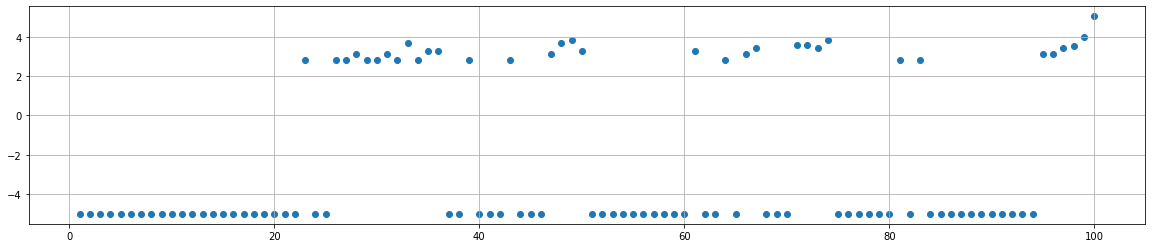

In [347]:
import math
print('90 and above',sum([c[i/100] for i in range(90,101,1)]))
print('55 to 90',sum([c[i/100] for i in range(55,91,1)]))
print('45 to 55',sum([c[i/100] for i in range(45,56,1)]))
print('25 to 50',sum([c[i/100] for i in range(25,51,1)]))
print('1 to 25',sum([c[i/100] for i in range(1,26,1)]))
print([c[i/100] for i in range(25,51,1)])
plt.figure(figsize=(20,4))
plt.grid()
plt.scatter(range(1,101,1),[math.log10(c[i/100] + 1e-5) for i in range(1,101,1)]);

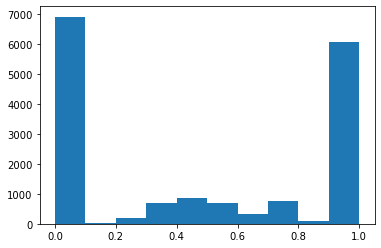

In [ ]:
plt.hist(bet_ratios,10,(0,1));

(array([2929., 1126., 1610., 2079., 2355., 1655., 1154.,  264.,   83.,
          14.]),
 array([ 1. ,  3.3,  5.6,  7.9, 10.2, 12.5, 14.8, 17.1, 19.4, 21.7, 24. ]),
 <BarContainer object of 10 artists>)

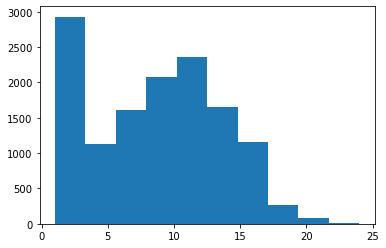

In [159]:
import numpy as np

plt.hist(num_actions)